# Who's the Better Carry: ADC or Midlaner?

**Name(s)**: Katelyn Villamin and Nancy Shen

**Website Link**: (your website link)

In [38]:
import pandas as pd
import numpy as np
from pathlib import Path

import plotly.express as px
pd.options.plotting.backend = 'plotly'

from dsc80_utils import *

## Step 1: Introduction

### **TO ASK:**

1. Missingness: After doing permutation test, how to tell if it's MAR or MCAR?
2. How to find the distribution of the games won where ADC had more total damage than mid and vice versa (how to see the data game by game, our idea is to use team position)
    - Length of adc and mid doesn't match (WHY!!!)

Which role carries the most in winning teams: ADCs or Midlanders?

Things to consider: 
- deaths per minute
- kills per minute
- KDA
- cs per minute (gold)
- Winning teams only 
- double/triple/quadra/penta kills 

## Step 2: Data Cleaning and Exploratory Data Analysis

In [39]:
#import dataset from data folder
league_fp = Path('data') / '2022_LoL_esports_match_data_from_OraclesElixir.csv'
league = pd.read_csv(league_fp, low_memory=False)

#isolate the columns needed
columns_needed = ['year', 'league', 'teamname', 'position', 'kills', 'deaths', 'assists', 'doublekills', 'damagetochampions', 'dpm', 'earnedgold', 'earned gpm', 'firstbloodkill', 'towers', 'result', 'dragons']
league = league[columns_needed]

#since we're looking at the 2022 dataset make sure all the games are completed in 2022
league = league[league['year'] == 2022]

#change all the position column values that are 'bot' to 'adc' for clarity
league['position'] = league['position'].str.replace('bot', 'adc')

#change column names to more appropriate ones
league.rename(columns={
    "damagetochampions": "total damage dealt", 
    "earnedgold": "total gold earned", 
    "earned gpm": "gpm", 
    "firstbloodkill": "first blood kill",
    "teamname" : "team name"
    }, inplace=True)

#change 'first blood kill' and 'result' to booleans
league["first blood kill"] = league["first blood kill"].astype(bool)
league["result"] = league["result"].astype(bool)
league

,year,league,team name,position,...,first blood kill,towers,result,dragons
0,2022,LCKC,Fredit BRION Challengers,top,...,False,NaN,False,NaN
1,2022,LCKC,Fredit BRION Challengers,jng,...,False,NaN,False,NaN
2,2022,LCKC,Fredit BRION Challengers,mid,...,False,NaN,False,NaN
...,...,...,...,...,...,...,...,...,...
148989,2022,DCup,Bilibili Gaming,sup,...,False,NaN,True,NaN
148990,2022,DCup,ThunderTalk Gaming,team,...,True,0.0,False,0.0
148991,2022,DCup,Bilibili Gaming,team,...,True,10.0,True,4.0


| Column | Description|
| --- | --- |
| `'year'` | the year the games took place in|
| `'league'` | The league in which the players and teams play in |
| `'team name'` | The team each player plays for |
| `'position'` | The role of the player in the game |
| `'kills'` | Total number of kills a player has in a game |
| `'deaths'` | Total number of times a player dies in a game |
| `'assists'` | Total number of assits a player has in a game |
| `'doublekills'` | Total number of times a player kills an two opponents consecutively |
| `'total damage dealt'` | Total damage dealt to enemy champions by player|
| `'dpm'` | Average damage dealt to enemy champions per minute by player|
| `'total gold earned'` | Total gold earned by player in a game (excludes starting gold and inherent gold generation) |
| `'gpm'` | Average gold earned per minute by player (excludes starting gold and inherent gold generation) |
| `'first blood kill'` | Whether the player got the first kill |
| `'result'` | Whether or not the team won that game |

In [40]:
#create a df with just mid and adc positions
mid_adc = league[(league['position'].str.lower() == 'adc') | (league['position'].str.lower() == 'mid')]
mid_adc

,year,league,team name,position,...,first blood kill,towers,result,dragons
2,2022,LCKC,Fredit BRION Challengers,mid,...,False,NaN,False,NaN
3,2022,LCKC,Fredit BRION Challengers,adc,...,False,NaN,False,NaN
7,2022,LCKC,Nongshim RedForce Challengers,mid,...,False,NaN,True,NaN
...,...,...,...,...,...,...,...,...,...
148983,2022,DCup,ThunderTalk Gaming,adc,...,False,NaN,False,NaN
148987,2022,DCup,Bilibili Gaming,mid,...,False,NaN,True,NaN
148988,2022,DCup,Bilibili Gaming,adc,...,False,NaN,True,NaN


**Univariate Analysis**
- distribution of kills 
- distribution of total damage dealt 
- each graph will have two bell curves one for mid one for bot

In [41]:
#get the killcounts for mid and adc positions
mid_kills = mid_adc[mid_adc['position'] == 'mid']['kills'].value_counts()
adc_kills = mid_adc[mid_adc['position'] == 'adc']['kills'].value_counts()

#create new df with only mid_kills and adc_kills data
kills_distr = pd.DataFrame()
kills_distr['adc'] = adc_kills
kills_distr['mid'] = mid_kills

#fill NaN values with 0
kills_distr['mid'] = kills_distr['mid'].fillna(0)
kills_distr['adc'] = kills_distr['adc'].fillna(0)


#reset index so that we can see the number of times each role got a certain amount of kills
kills_distr = kills_distr.reset_index()

#rename the index column 
kills_distr.rename(columns={'index': 'num kills'}, inplace=True)

#sort df values so that when plotting, the values will create a curve
kills_distr = kills_distr.sort_values(by='num kills')

kills_distr

,num kills,adc,mid
5,0,2272,2617.0
0,1,3151,3831.0
1,2,3141,3949.0
...,...,...,...
21,22,3,0.0
24,24,1,0.0
23,28,1,0.0


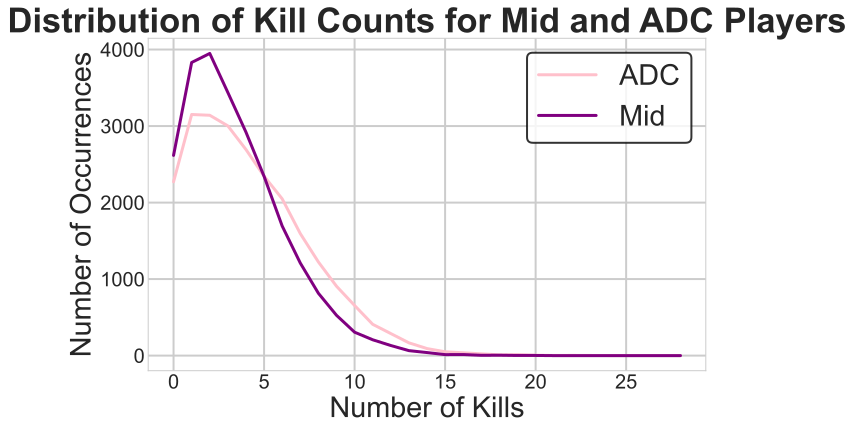

In [42]:
#set a style for the plot
plt.style.use('seaborn-whitegrid')

#plot the graph
plt.figure(figsize=(10, 6))
plt.plot(kills_distr['num kills'], kills_distr['adc'], label='ADC', linestyle='-', color='pink')
plt.plot(kills_distr['num kills'], kills_distr['mid'], label='Mid', linestyle='-', color='purple')

#style the graph
plt.xlabel("Number of Kills", fontsize= 'large')
plt.ylabel("Number of Occurrences", fontsize= 'large')
plt.title('Distribution of Kill Counts for Mid and ADC Players', fontsize= 'x-large', fontweight= 'bold')
plt.xticks(fontsize= 'small')
plt.yticks(fontsize= 'small')
plt.legend(["ADC", "Mid"], loc='upper right', frameon=True, edgecolor='black', facecolor='white', fontsize= 'large')

plt.show()

**Bivariate Analysis**
- Distribution of Getting First Blood Kill Given a Position (mid/adc)

In [43]:
#separate when mid players got a first kill and when they didnt
mid_first= mid_adc[(mid_adc['position']== 'mid') & (mid_adc['first blood kill']== True)]
mid_nofirst= mid_adc[(mid_adc['position']== 'mid') & (mid_adc['first blood kill']== False)]

#separate when adc players got a first kill and when they didnt
adc_first= mid_adc[(mid_adc['position']== 'adc') & (mid_adc['first blood kill']== True)]
adc_nofirst= mid_adc[(mid_adc['position']== 'adc') & (mid_adc['first blood kill']== False)]

#get the total number of first blood kills of mid and adc players
total=mid_adc['first blood kill'].count()

#get the proportions of when either role has kills vs no kills
kills = [(mid_first['first blood kill'].count()/total)*100, (adc_first['first blood kill'].count()/total)*100]
no_kills = [(mid_nofirst['first blood kill'].count()/total)*100, (adc_nofirst['first blood kill'].count()/total)*100]

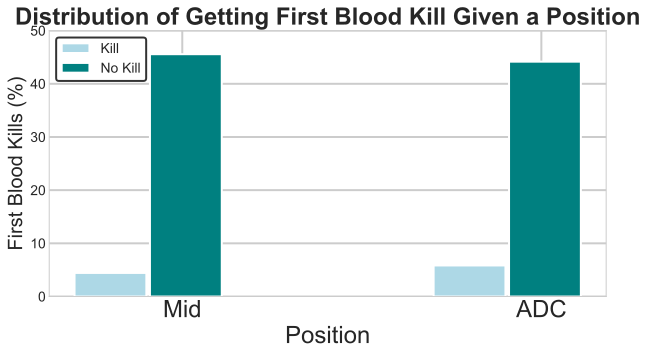

In [44]:
#plot bar graph
x = np.arange(2)
width = 0.2
plt.bar(x - 0.2, kills, width, color='lightblue')
plt.bar(x + 0.01, no_kills, width, color='teal')
plt.ylim(0, 50)

#style graph
plt.xlabel("Position", fontsize= 'medium')
plt.ylabel("First Blood Kills (%)", fontsize= 'small')
plt.xticks(x, ['Mid', 'ADC'], fontsize= 'medium')
plt.yticks(fontsize= 'xx-small')
plt.title("Distribution of Getting First Blood Kill Given a Position", fontsize= 'medium', fontweight= 'bold')
plt.legend(["Kill", "No Kill"], loc='best', frameon=True, edgecolor='black', facecolor='white', fontsize= 'xx-small')
plt.subplots_adjust(top=0.85)

# show plot
plt.show()

**Interesting Aggregates**

This table shows the mean statistics for ADC and mid players in dataset based on the result of the game (where False means that they lost, and True means that they won). Finding the means of these columns allows us to see which role carries more often.

In [45]:
aggregates = mid_adc.groupby(['position', 'result']).mean()

#drop towers because towers only applies to 'position' == 'team'
aggregates = aggregates.drop(columns='towers')
aggregates

year  kills  deaths  assists  ...  total gold earned  \
position result                                  ...                      
adc      False   2022.0   2.58    3.51     3.39  ...            8264.87   
         True    2022.0   5.94    1.58     7.34  ...           10769.42   
mid      False   2022.0   2.25    3.61     3.65  ...            7407.34   
         True    2022.0   4.74    1.69     8.13  ...            9504.98   

                    gpm  first blood kill  dragons  
position result                                     
adc      False   257.34              0.09      NaN  
         True    342.73              0.14      NaN  
mid      False   231.99              0.07      NaN  
         True    302.96              0.11      NaN  

[4 rows x 11 columns]

## Step 3: Assessment of Missingness

In [46]:
#make a separate df with only data for position == team so we don't get duplicates
teams_only = league[league['position']== 'team']
teams_only

,year,league,team name,position,...,first blood kill,towers,result,dragons
10,2022,LCKC,Fredit BRION Challengers,team,...,True,3.0,False,1.0
11,2022,LCKC,Nongshim RedForce Challengers,team,...,True,6.0,True,3.0
22,2022,LCKC,T1 Challengers,team,...,True,3.0,False,1.0
...,...,...,...,...,...,...,...,...,...
148979,2022,DCup,ThunderTalk Gaming,team,...,True,2.0,False,1.0
148990,2022,DCup,ThunderTalk Gaming,team,...,True,0.0,False,0.0
148991,2022,DCup,Bilibili Gaming,team,...,True,10.0,True,4.0


### **Double Kills vs League**


When Double Kills is Missing. We use data of `teams_only`

**When double kills is missing:**

In [47]:
#get totall number of doublekills
total_doublekills = teams_only['doublekills'].sum()
league_prop_missing = (teams_only.groupby('league')['doublekills'].sum() / total).reset_index()
league_prop_missing.head().style.format({'doublekills': '{:.8f}'.format})

,league,doublekills
0,CBLOL,0.01628408
1,CBLOLA,0.01522748
2,CDF,0.00673324
3,CT,0.00188531
4,DCup,0.00000000


In [48]:
#helper function for imputing missing variables
def prob_impute(s):
    s = s.copy()
    num_null = s.isna().sum()
    fill_values = np.random.choice(s.dropna(), num_null)
    s[s.isna()] = fill_values
    return s

In [49]:
#create a copy of teams_only
team_filled = teams_only.copy()

#isolate the columns that we want
team_filled= team_filled[['league', 'doublekills']]

#call the helper function on teams_filled
team_filled['doublekills'] = (
    teams_only
    ['doublekills']
    .transform(prob_impute)
)

#get total number of doublekills after imputation
total= team_filled['doublekills'].sum()

#get the proportion of doublekills when it's not missing
league_prop_notmissing = (team_filled.groupby('league')['doublekills'].sum() / total).reset_index()
league_prop_notmissing.head().style.format({'doublekills': '{:.8f}'.format})

,league,doublekills
0,CBLOL,0.01925527
1,CBLOLA,0.01800588
2,CDF,0.00796178
3,CT,0.00222930
4,DCup,0.00658991


# **LOOK HERE**

**Permutation Test of League vs. Doublekills**

In [50]:
league_double = teams_only[['league', 'doublekills']]
league_double_dist = (
    league_double
    .assign(double_missing=league_double['doublekills'].isna())
    .pivot_table(index='league', columns='double_missing', aggfunc='size')
)

# Added just to make the resulting pivot table easier to read.
league_double_dist.columns = ['double_missing = False', 'double_missing = True']

league_double_dist = league_double_dist / league_double_dist.sum()
league_double_dist

,double_missing = False,double_missing = True
league,,
CBLOL,2.37e-02,NaN
CBLOLA,2.11e-02,NaN
CDF,7.12e-03,NaN
...,...,...
VCS,3.15e-02,NaN
VL,1.52e-02,NaN
WLDs,1.38e-02,7.70e-03


In [51]:
observed_tvd_league = league_double_dist.diff(axis=1).iloc[:, -1].abs().sum() / 2
observed_tvd_league

0.0030311228214282494

In [52]:
n_repetitions = 500
shuffled_league = league_double.copy()
shuffled_league= shuffled_league.assign(double_missing=league_double['doublekills'].isna())

tvds_league = []
for _ in range(n_repetitions):
    
    
    shuffled_league['league'] = np.random.permutation(shuffled_league['league'])
    
    pivoted_league = (
        shuffled_league
        .pivot_table(index='league', columns='double_missing', aggfunc='size')
    )
    
    pivoted_league = pivoted_league / pivoted_league.sum()
    
    tvd = pivoted_league.diff(axis=1).iloc[:, -1].abs().sum() / 2
    tvds_league.append(tvd)

In [53]:
pval = (pd.Series(tvds_league) >= observed_tvd_league).mean()
pval

#Fail to Reject

1.0

In [54]:
fig = px.histogram(pd.DataFrame(tvds_league), x=0, nbins=50, histnorm='probability', 
                   title='Empirical Distribution of the TVD')
fig.add_vline(x=observed_tvd_league, line_color='red')
fig.add_annotation(text=f'<span style="color:red">Observed TVD = {round(observed_tvd_league, 2)}</span>',
                   x=2.3 * observed_tvd_league, showarrow=False, y=0.16)
fig.update_layout(yaxis_range=[0, 0.2])

**conclusion**:

### **DoubleKills vs Towers: Missing at Random**

- When DoubleKills is Missing

In [55]:
towers_double = teams_only[['towers', 'doublekills']]
towers_double_dist = (
    towers_double
    .assign(double_missing=towers_double['doublekills'].isna())
    .pivot_table(index='towers', columns='double_missing', aggfunc='size')
)

# Added just to make the resulting pivot table easier to read.
towers_double_dist.columns = ['double_missing = False', 'double_missing = True']

towers_double_dist = towers_double_dist / towers_double_dist.sum()
towers_double_dist

,double_missing = False,double_missing = True
towers,,
0.0,0.05,0.04
1.0,0.08,0.09
2.0,0.11,0.11
...,...,...
9.0,0.14,0.15
10.0,0.12,0.13
11.0,0.11,0.09


In [56]:
observed_tvd_tower = towers_double_dist.diff(axis=1).iloc[:, -1].abs().sum() / 2
observed_tvd_tower

0.03472890994914897

In [57]:
n_repetitions = 500
shuffled_towers = towers_double.copy()
shuffled_towers= shuffled_towers.assign(double_missing=towers_double['doublekills'].isna())

tvds_towers = []
for _ in range(n_repetitions):
    
    
    shuffled_towers['towers'] = np.random.permutation(shuffled_towers['towers'])
    
    pivoted_towers = (
        shuffled_towers
        .pivot_table(index='towers', columns='double_missing', aggfunc='size')
    )
    
    pivoted_towers = pivoted_towers / pivoted_towers.sum()
    
    tvd = pivoted_towers.diff(axis=1).iloc[:, -1].abs().sum() / 2
    tvds_towers.append(tvd)

In [58]:
pval = (pd.Series(tvds_towers) >= observed_tvd_tower).mean()
pval

#Reject?

0.026

In [59]:
fig = px.histogram(pd.DataFrame(tvds_towers), x=0, nbins=50, histnorm='probability', 
                   title='Empirical Distribution of the TVD')
fig.add_vline(x=observed_tvd_tower, line_color='red')
fig.add_annotation(text=f'<span style="color:red">Observed TVD = {round(observed_tvd_tower, 2)}</span>',
                   x=2.3 * observed_tvd_tower, showarrow=False, y=0.16)
fig.update_layout(yaxis_range=[0, 0.2])

### **DoubleKills vs Dragons: Missing Completely at Random**

- When DoubleKills is Missing

In [60]:
#Observed
observed_diff_dragons = teams_only.groupby('dragons')['doublekills'].mean().diff().abs().iloc[-1]
observed_diff_dragons

0.6129032258064515

In [61]:
#get proportion when doublekills is missing
tower_prop_missing = (teams_only.groupby('dragons')['doublekills'].sum() / total).reset_index()
tower_prop_missing.head().style.format({'doublekills': '{:.8f}'.format})

,dragons,doublekills
0,0.00,0.03192063
1,1.00,0.09911808
2,2.00,0.20110240
3,3.00,0.24220970
4,4.00,0.23150416


- When DoubleKills is not Missing

In [62]:
#create a copy of teams_only
dragons_filled = teams_only.copy()

#isolate the columns that we want
dragons_filled = dragons_filled[['dragons', 'doublekills']]

#call the helper function on teams_filled
dragons_filled['doublekills'] = (
    teams_only
    ['doublekills']
    .transform(prob_impute)
)
total= dragons_filled['doublekills'].sum()
dragons_prop_notmissing = (dragons_filled.groupby('dragons')['doublekills'].sum() / total).reset_index()
dragons_prop_notmissing.head().style.format({'doublekills': '{:.8f}'.format})

,dragons,doublekills
0,0.00,0.05279511
1,1.00,0.12895413
2,2.00,0.23493578
3,3.00,0.27902141
4,4.00,0.26125994


In [63]:
#Permutation Test on Dragons vs Double Kills
n_repetitions = 10000
shuffled_dragons = teams_only.copy()

diff_means_dragons = []
for _ in range(n_repetitions):
    shuffled_dragons['dragons'] = np.random.permutation(shuffled_dragons['dragons'])
    
    # computing and storing the difference in means.
    pivoted_dragons = (
        shuffled_dragons
        .pivot_table(index='dragons', columns='doublekills', aggfunc='size')
    )
    
    pivoted_dragons = pivoted_dragons / pivoted_dragons.sum()
    diff_mean_dragon = shuffled_dragons.groupby('dragons')['doublekills'].mean().diff().abs().iloc[-1]
    diff_means_dragons.append(diff_mean_dragon)

In [64]:
diff_means_dragons

[0.8214285714285714,
 1.6296296296296295,
 0.8148148148148149,
 0.5,
 0.5652173913043479,
 nan,
 1.4166666666666667,
 1.7083333333333333,
 2.869565217391304,
 0.4814814814814814,
 2.875,
 nan,
 nan,
 1.3043478260869565,
 0.15999999999999992,
 2.1379310344827585,
 1.4814814814814814,
 2.0714285714285716,
 0.13793103448275867,
 2.6,
 0.19354838709677424,
 1.7083333333333333,
 3.12,
 nan,
 nan,
 nan,
 1.3703703703703705,
 1.9090909090909092,
 nan,
 0.9285714285714286,
 0.1428571428571428,
 1.3333333333333333,
 2.333333333333333,
 0.9166666666666667,
 0.5555555555555556,
 1.1111111111111112,
 2.0,
 1.8214285714285714,
 2.1481481481481484,
 nan,
 0.1923076923076925,
 1.962962962962963,
 0.5357142857142858,
 1.6785714285714286,
 1.48,
 0.6538461538461537,
 1.7272727272727273,
 2.310344827586207,
 4.064516129032258,
 1.875,
 0.5652173913043479,
 1.1923076923076923,
 1.5714285714285714,
 nan,
 1.6296296296296295,
 nan,
 1.32,
 1.1481481481481481,
 0.48,
 1.076923076923077,
 nan,
 1.84,
 1.0909

In [65]:
#plot the graph
fig = px.histogram(pd.DataFrame(diff_means_dragons), x=0, nbins=50, histnorm='probability', 
                   title='Empirical Distribution of the Absolute Difference in Means')
fig.add_vline(x=observed_diff_dragons, line_color='red', line_width=1, opacity=1)
fig.add_annotation(text=f'<span style="color:red">Observed Absolute Difference in Means = {round(observed_diff_dragons, 2)}</span>',
                   x=2 * observed_diff_dragons, showarrow=False, y=0.07)

## Step 4: Hypothesis Testing

H0: The distribution of games won where ADC players had more damage on average than mid players is equal to the distribution of games won where mid players had more damage than ADC players

H1: The distribution of games won where ADC players had more damage on average than mid players is not equal to the distribution of games won where mid players had more damage than ADC players

# **LOOK HERE**

In [66]:
#create new df from mid_adc df with result == True
wins_only = mid_adc[mid_adc['result'] == True]
wins_only.dropna(subset=['total damage dealt'], inplace=True)
#isolate columns needed
wins_only = wins_only[['league', 'team name', 'position', 'total damage dealt']]

#create array where we have two identical values representing each game
arr = np.arange(0, wins_only.shape[0] / 2)
arr = np.repeat(arr, 2)

#assign array to df
wins_only['game no.'] = arr.astype(int)
wins_only


,league,team name,position,total damage dealt,game no.
7,LCKC,Nongshim RedForce Challengers,mid,20690.0,0
8,LCKC,Nongshim RedForce Challengers,adc,26687.0,0
19,LCKC,Liiv SANDBOX Challengers,mid,11261.0,1
...,...,...,...,...,...
148971,DCup,Bilibili Gaming,adc,30424.0,12062
148987,DCup,Bilibili Gaming,mid,19185.0,12063
148988,DCup,Bilibili Gaming,adc,28282.0,12063


In [67]:
#pivot table to see total damage dealt for mid players and adc players per game.
pivoted_wins = wins_only.pivot(columns='position', index='game no.', values='total damage dealt')

In [68]:
#create a df of games where mid has more damage than adc
mid_more_damage = pivoted_wins.loc[pivoted_wins['mid'] > pivoted_wins['adc']]
mid_more_damage= mid_more_damage.drop(columns= 'adc')
mid_more_damage['role']= 'mid'
mid_more_damage

position,mid,role
game no.,,
2,12577.0,mid
3,19759.0,mid
4,17636.0,mid
...,...,...
12055,24403.0,mid
12057,22281.0,mid
12061,14994.0,mid


In [69]:
#create a df of games where adc has more damage than mid
adc_more_damage = pivoted_wins.loc[pivoted_wins['adc'] > pivoted_wins['mid']]
adc_more_damage= adc_more_damage.drop(columns= 'mid')
adc_more_damage['role']= 'adc'
adc_more_damage

position,adc,role
game no.,,
0,26687.0,adc
1,16970.0,adc
5,17519.0,adc
...,...,...
12060,11584.0,adc
12062,30424.0,adc
12063,28282.0,adc


In [70]:
#Join the two pivoted columns based on position
joined= pd.concat([mid_more_damage, adc_more_damage])
#Fill the NaN values
joined= joined.fillna(0)

#Create a new column of the 'max damage dealt' and rename joined as only the role vs max damage dealt
joined['max damage dealt']= joined['adc'] + joined['mid'] 
joined= joined[['role', 'max damage dealt']]
joined

position,role,max damage dealt
game no.,,
2,mid,12577.0
3,mid,19759.0
4,mid,17636.0
...,...,...
12060,adc,11584.0
12062,adc,30424.0
12063,adc,28282.0


In [71]:
#Observed Absolute Difference in Means of Max Damage Dealt between Mid and ADC
observed_diff_dmg = joined.groupby('role')['max damage dealt'].mean().diff().abs().iloc[-1]
observed_diff_dmg

545.821638930971

In [72]:
#Permutation to test our Hypothesis

n_repetitions = 500

differences_dmg = []
for _ in range(n_repetitions):
    #Shuffle the column 'max damage dealt' and randomly permutate it in another column
    with_shuffled = joined.assign(shuffled_max_damage_dealt=np.random.permutation(joined['max damage dealt']))

    #Get the difference in means between mid and adc for the shuffled cases
    group_means = (
        with_shuffled
        .groupby('role')
        .mean()
        .loc[:, 'shuffled_max_damage_dealt']
    )
    difference = group_means.diff().abs().iloc[-1]
    
    #Store the result
    differences_dmg.append(difference)
    
differences_dmg[:10]

[26.51290478518422,
 115.6294857503126,
 116.76066711007297,
 162.80773116425553,
 17.391943227736192,
 110.13247828758176,
 337.9476980424988,
 78.66709410732074,
 158.54739993340627,
 245.7616592550039]

In [73]:
pval = (pd.Series(differences_dmg) >= observed_diff_dmg).mean()
pval

#REJECT! 0 < 0.05

0.002

In [75]:
#Plot the distribution 
fig = px.histogram(
    pd.DataFrame(differences_dmg), x=0, nbins=50, histnorm='probability', 
    title='Empirical Distribution of the Mean Differences <br> in Max Damage Dealt |Mid - ADC|')
fig.add_vline(x=observed_diff_dmg, line_color='red', line_width=1, opacity=1)
fig.update_layout(xaxis_range=[-10, 10], margin=dict(t=60))

## Step 5: Framing a Prediction Problem

Clearly state your prediction problem and type (classification or regression). If you are building a classifier, make sure to state whether you are performing binary classification or multiclass classification. Report the response variable (i.e. the variable you are predicting) and why you chose it, the metric you are using to evaluate your model and why you chose it over other suitable metrics (e.g. accuracy vs. F1-score).

- Our prediction problem is: Given a dataset of post-game stats, we want to predict which role did they play. To predict the response variable (position), we will be using a multiclass classification. We chose the position as the response variable because there are clear defined criterias for post game statistics for us to draw our model from. 

Evaluation Metrics

- Accuracy : It is one of the most straightforward metrics used in machine learning. It defines how accurate your model is. For example, if you build a model that classifies 90 samples accurately, your accuracy is 90% or 0.90. If only 83 samples are classified correctly, the accuracy of your model is 83% or 0.83. Simple.


- Precision: is the ratio of correctly predicted positive observations to the total predicted positive observations. The question that this metric answer is of all passengers that labeled as survived, how many actually survived? High precision relates to the low false positive rate. We have got 0.788 precision which is pretty good. True Positives (TP) - These are the correctly predicted positive values which means that the value of actual class is yes and the value of predicted class is also yes. E.g. if actual class value indicates that this passenger survived and predicted class tells you the same thing. True Negatives (TN) - These are the correctly predicted negative values which means that the value of actual class is no and value of predicted class is also no. E.g. if actual class says this passenger did not survive and predicted class tells you the same thing. False positives and false negatives, these values occur when your actual class contradicts with the predicted class. False Positives (FP) – When actual class is no and predicted class is yes. E.g. if actual class says this passenger did not survive but predicted class tells you that this passenger will survive. False Negatives (FN) – When actual class is yes but predicted class in no. E.g. if actual class value indicates that this passenger survived and predicted class tells you that passenger will die.Approch To compute precision of multi class classification problem. There are two different ways to calculate this which might get confusing from time to time. We know that precision depends on true positives and false positives. Macro averaged precision: calculate precision for all classes individually and then average them. Micro averaged precision: calculate class wise true positive and false positive and then use that to calculate overall precision

- Recall(Sensitivity) : Recall is the ratio of correctly predicted positive observations to the all observations in actual class - yes. The question recall answers is: Of all the passengers that truly survived: Recall = TP / (TP + FN). Approch To compute recall of multi class classification problem There are two different ways to calculate this which might get confusing from time to time. We know that recall depends on true positives and false negatives. Macro averaged recall: calculate recall for all classes individually and then average them. Micro averaged recall: calculate class wise true positive and false negative and then use that to calculate overall recall

- F1 score (F1) : F1 Score is the weighted average of Precision and Recall. Therefore, this score takes both false positives and false negatives into account. Intuitively it is not as easy to understand as accuracy. F1 is usually more useful than accuracy, especially if you have an uneven class distribution. Accuracy works best if false positives and false negatives have similar cost. If the cost of false positives and false negatives are very different, it’s better to look at both Precision and Recall. In our case, F1 score is 0.701.

Create, or engineer, features to best reflect the "meaning" behind data.
Choose a model that is appropriate to capture the relationships between features (X) and the target/response (y).
Choose a loss function, e.g. squared loss.
Fit the model: that is, minimize empirical risk to find optimal model parameters 
w∗.
Evaluate the model, e.g. using RMSE or  R2.

## Step 6: Baseline Model

In [76]:
league

,year,league,team name,position,...,first blood kill,towers,result,dragons
0,2022,LCKC,Fredit BRION Challengers,top,...,False,NaN,False,NaN
1,2022,LCKC,Fredit BRION Challengers,jng,...,False,NaN,False,NaN
2,2022,LCKC,Fredit BRION Challengers,mid,...,False,NaN,False,NaN
...,...,...,...,...,...,...,...,...,...
148989,2022,DCup,Bilibili Gaming,sup,...,False,NaN,True,NaN
148990,2022,DCup,ThunderTalk Gaming,team,...,True,0.0,False,0.0
148991,2022,DCup,Bilibili Gaming,team,...,True,10.0,True,4.0


Columns for Baseline Model: Position, Champion, Total Damage Dealt (Champions)

In [127]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression

#Create a dataframe from the original dataset pulling the columns 'position', 'champion, and 'damage to champion'
baseline = pd.read_csv(league_fp, low_memory=False)
baseline= baseline[['position', 'champion', 'damagetochampions']]

#Filtering out the rows with position 'team'
baseline= baseline[baseline['position']!= 'team']

#Rename 'damagetochampions' as 'total damage dealt'
baseline.rename(columns={'damagetochampions': 'total damage dealt'}, inplace= True)
baseline.dropna(subset=['total damage dealt'], inplace=True)
baseline

,position,champion,total damage dealt
0,top,Renekton,15768.0
1,jng,Xin Zhao,11765.0
2,mid,LeBlanc,14258.0
...,...,...,...
148987,mid,Ahri,19185.0
148988,bot,Varus,28282.0
148989,sup,Ashe,10950.0


In [ ]:
# ohe = OneHotEncoder()
# ohe.fit(baseline[['position','champion']])
# pd.DataFrame(ohe.transform(baseline[['position','champion']]).toarray(), 
#              columns=ohe.get_feature_names_out())


In [140]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

preproc = ColumnTransformer(
    transformers=[
        ('', OneHotEncoder(), ['position', 'champion'])
    ],
    remainder='passthrough' # Specify what to do with all other columns ('total_bill' here) – drop or passthrough.
)
pl = Pipeline([
    ('preprocessor', preproc)])
pd.DataFrame(pl.fit_transform(baseline[['position','champion']]).toarray(), 
             columns=pl.get_feature_names_out())

,__position_bot,__position_jng,__position_mid,__position_sup,...,__champion_Ziggs,__champion_Zilean,__champion_Zoe,__champion_Zyra
0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
124147,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0
124148,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0
124149,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0


Support: Highest Vision Score, Most Control Wards Bought, More Assists, Low Damage
Jung: Monsters Killed
Top: Highest Damage Mitigated

## Step 7: Final Model

## Step 8: Fairness Analysis